<a href="https://colab.research.google.com/github/Swanimadhoop/RL_snakeGame/blob/main/RL_SnakeGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reinforcement learning - snake game

Project: Snake Reinforcement Learning using TD Q-Learning and Deep Q-Networks (DQN)
Description

This project implements a custom Snake game environment in which an autonomous agent learns to collect food and avoid collisions using Temporal Difference (TD) Q-learning and an extended Deep Q-Network (DQN) approach. The snake grows in length upon consuming food, and multiple food items are introduced to increase environmental complexity.

The learning process is analyzed using reward curves and visualized through animated gameplay episodes. The tabular TD Q-learning method is first implemented as a baseline and then scaled to a DQN using neural function approximation, experience replay, and target networks to handle larger state spaces and stabilize training.

Features

Tabular TD Q-learning for step-by-step policy learning.

Deep Q-Network (DQN) with neural function approximation.

Experience replay buffer and target network for stable learning.

Growing snake tail and multiple food items for increased complexity.

Animation of the final training episodes showing learned behavior.

Reward curves comparing learning performance over episodes.

GIF visualization (snake_learning.gif) of the agent’s learning progression.


In [1]:
# Step 0: Imports
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from IPython.display import display, clear_output
import time

In [2]:


# Step 1: Snake Environment
class SnakeEnv:
    def __init__(self, grid_size=8, n_foods=2):
        self.grid_size = grid_size
        self.n_foods = n_foods
        self.reset()

    def reset(self):
        self.snake = [(self.grid_size//2, self.grid_size//2)]
        self.foods = []  # initialize before placing foods
        self.foods = [self._place_food() for _ in range(self.n_foods)]
        self.done = False
        self.total_reward = 0
        return self._get_state()

    def _place_food(self):
        while True:
            pos = (random.randint(0, self.grid_size-1), random.randint(0, self.grid_size-1))
            if pos not in self.snake and pos not in self.foods:
                return pos

    def _get_state(self):
        head = self.snake[0]
        food_state = tuple([f for food in self.foods for f in food])
        return (head + food_state)

    def step(self, action):
        if self.done:
            return self._get_state(), 0, self.done

        x, y = self.snake[0]
        if action == 0: y -= 1
        elif action == 1: y += 1
        elif action == 2: x -= 1
        elif action == 3: x += 1

        new_head = (x, y)

        # collisions
        if x < 0 or x >= self.grid_size or y < 0 or y >= self.grid_size or new_head in self.snake:
            self.done = True
            reward = -10
        elif new_head in self.foods:
            self.snake.insert(0, new_head)
            self.foods.remove(new_head)
            self.foods.append(self._place_food())
            reward = 10
        else:
            self.snake.insert(0, new_head)
            self.snake.pop()
            reward = -1

        self.total_reward += reward
        return self._get_state(), reward, self.done

    def render_grid(self):
        grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8)
        for food in self.foods:
            grid[food[1], food[0]] = [255,0,0]  # red food
        for i, segment in enumerate(self.snake):
            grid[segment[1], segment[0]] = [0,255,0] if i==0 else [0,200,0]
        return grid

    def render_display(self, scale=50):
        grid = self.render_grid()
        plt.imshow(np.kron(grid.astype(np.uint8), np.ones((scale,scale,1), dtype=np.uint8)), interpolation='none')
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)

In [3]:


# Step 2: RL parameters
n_actions = 4
epsilon = 0.5
epsilon_decay = 0.995
alpha = 0.1
gamma = 0.9
n_episodes = 300

# Initialize Q-values with small random numbers
Q_td = defaultdict(lambda: np.random.uniform(-0.01,0.01,n_actions))
episode_rewards = []

In [4]:


# Step 3: Epsilon-greedy policy
def choose_action(state):
    if random.random() < epsilon:
        return random.randint(0,n_actions-1)
    return np.argmax(Q_td[state])

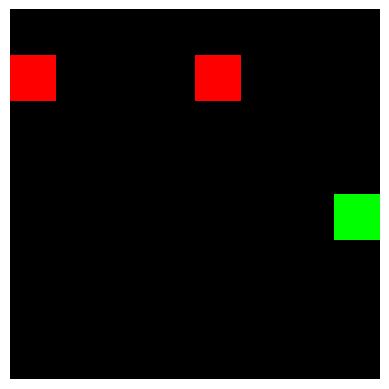

In [5]:


# Step 4: Training loop with frame storage
env = SnakeEnv(grid_size=8, n_foods=2)
frames_per_episode = []

for episode in range(n_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    episode_frames = []

    while not done:
        action = choose_action(state)
        next_state, reward, done = env.step(action)

        # TD Q-learning update
        Q_td[state][action] += alpha * (reward + gamma*np.max(Q_td[next_state]) - Q_td[state][action])
        state = next_state
        total_reward += reward

        # store frame
        episode_frames.append(env.render_grid())

    frames_per_episode.append(episode_frames)

    # decay epsilon
    epsilon *= epsilon_decay
    episode_rewards.append(total_reward)

    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

print("Training finished!")

# Step 5: Playback last 10 episodes with crisp visualization
for ep_num, ep_frames in enumerate(frames_per_episode[-10:]):
    print(f"Episode {n_episodes-10 + ep_num + 1}")
    for frame in ep_frames:
        plt.imshow(np.kron(frame.astype(np.uint8), np.ones((50,50,1), dtype=np.uint8)), interpolation='none')
        plt.axis('off')
        display(plt.gcf())
        clear_output(wait=True)
        time.sleep(0.05)



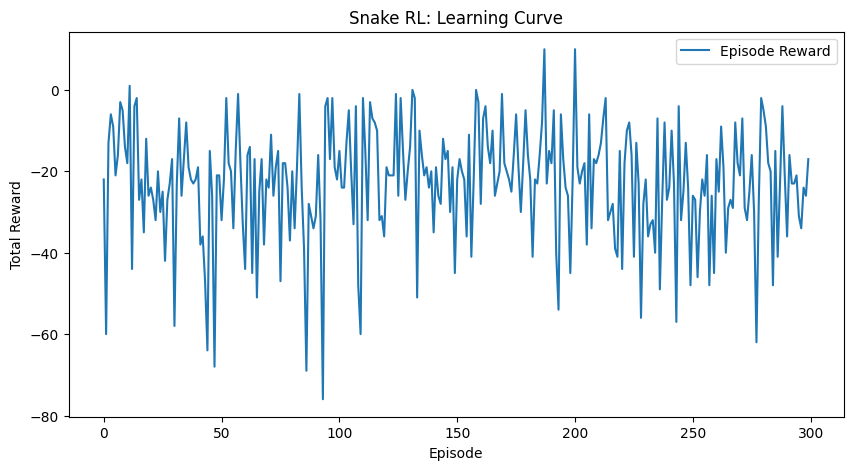

In [6]:
# Step 6: Plot learning curve
plt.figure(figsize=(10,5))
plt.plot(episode_rewards, label="Episode Reward")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Snake RL: Learning Curve")
plt.legend()
plt.show()


In [7]:
# Step 0: Imports
import imageio
import numpy as np

# Step 1: Collect frames from last 10 episodes
gif_frames = []

# frames_per_episode is a list of lists of grids (from training)
for ep_frames in frames_per_episode[-10:]:  # last 10 episodes
    for frame in ep_frames:
        # Convert frame to RGB image (uint8)
        img = np.kron(frame.astype(np.uint8), np.ones((40,40,1), dtype=np.uint8))
        gif_frames.append(img)

# Step 2: Save as GIF
imageio.mimsave("snake_learning.gif", gif_frames, duration=0.05)  # duration per frame in seconds

print("GIF saved as snake_learning.gif!")


GIF saved as snake_learning.gif!


In [8]:
imageio.mimsave("snake_learning.mp4", gif_frames, fps=20)
print("MP4 saved as snake_learning.mp4!")


MP4 saved as snake_learning.mp4!


In [18]:
s = env.reset()
print(type(s))
print(s)


<class 'tuple'>
(4, 4, 5, 4, 7, 6)


Episode 0 | Reward: -13 | Epsilon: 0.497


/tmp/ipython-input-470992879.py:73: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.FloatTensor(states).to(device)


Episode 20 | Reward: -28 | Epsilon: 0.450
Episode 40 | Reward: -78 | Epsilon: 0.407
Episode 60 | Reward: -16 | Epsilon: 0.368
Episode 80 | Reward: -70 | Epsilon: 0.333
Episode 100 | Reward: -28 | Epsilon: 0.301
Episode 120 | Reward: -29 | Epsilon: 0.273
Episode 140 | Reward: -4 | Epsilon: 0.247
Episode 160 | Reward: 0 | Epsilon: 0.223
Episode 180 | Reward: -4 | Epsilon: 0.202
Episode 200 | Reward: -19 | Epsilon: 0.183
Episode 220 | Reward: 15 | Epsilon: 0.165
Episode 240 | Reward: -2 | Epsilon: 0.149
Episode 260 | Reward: -10 | Epsilon: 0.135
Episode 280 | Reward: -46 | Epsilon: 0.122


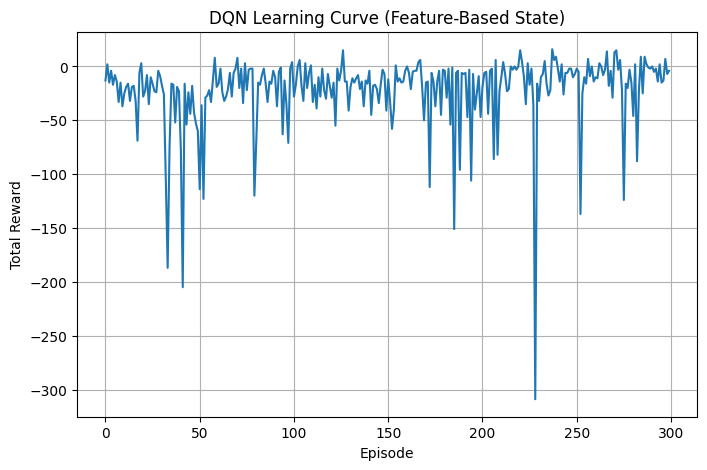

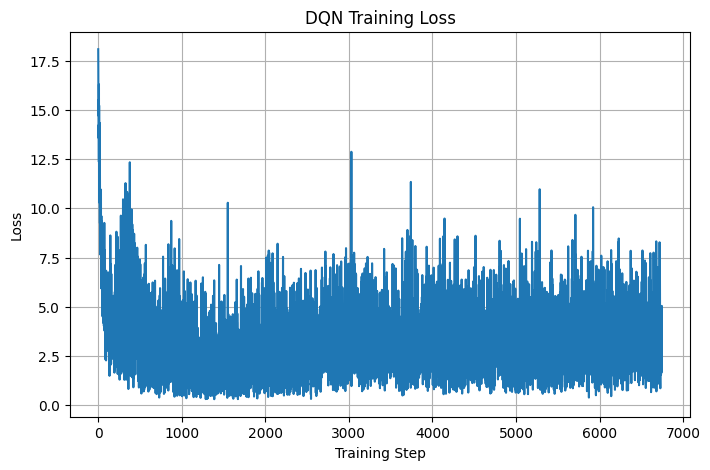

Average reward (last 50 episodes): -13.18
Maximum reward achieved: 16


In [20]:
# ===================== IMPORTS =====================
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# ===================== DQN MODEL =====================
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_size)
        )

    def forward(self, x):
        return self.net(x)

# ===================== STATE PROCESSING =====================
def process_state(state):
    """
    Environment returns a tuple of features.
    Convert directly to numpy array.
    """
    return np.array(state, dtype=np.float32)

# ===================== HYPERPARAMETERS =====================
state_size = 6        # IMPORTANT: matches (4,4,5,4,7,6)
action_size = 4
episodes = 300
batch_size = 64
lr = 0.001
gamma = 0.9
epsilon = 0.5
epsilon_min = 0.05
epsilon_decay = 0.995

# ===================== INITIALIZATION =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DQN(state_size, action_size).to(device)
target_model = DQN(state_size, action_size).to(device)
target_model.load_state_dict(model.state_dict())

optimizer = optim.Adam(model.parameters(), lr=lr)
memory = deque(maxlen=10000)

episode_rewards = []
episode_losses = []

# ===================== HELPERS =====================
def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, action_size - 1)

    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        return model(state).argmax().item()

def store_transition(s, a, r, s2, d):
    memory.append((s, a, r, s2, d))

def train_step():
    batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_vals = model(states).gather(1, actions.unsqueeze(1)).squeeze()
    next_q = target_model(next_states).max(1)[0]

    targets = rewards + (1 - dones) * gamma * next_q

    loss = nn.MSELoss()(q_vals, targets.detach())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# ===================== TRAINING LOOP =====================
for episode in range(episodes):
    state = process_state(env.reset())
    done = False
    total_reward = 0

    while not done:
        action = select_action(state, epsilon)
        next_state_raw, reward, done = env.step(action)
        next_state = process_state(next_state_raw)

        store_transition(state, action, reward, next_state, done)

        state = next_state
        total_reward += reward

        if len(memory) > batch_size:
            episode_losses.append(train_step())

    episode_rewards.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    if episode % 20 == 0:
        print(f"Episode {episode} | Reward: {total_reward} | Epsilon: {epsilon:.3f}")

# ===================== PLOTTING =====================
plt.figure(figsize=(8, 5))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Learning Curve (Feature-Based State)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(episode_losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("DQN Training Loss")
plt.grid(True)
plt.show()

print("Average reward (last 50 episodes):", np.mean(episode_rewards[-50:]))
print("Maximum reward achieved:", max(episode_rewards))


In [ ]:
"""
The DQN agent demonstrated partial learning in the custom Snake environment. Training curves show improved average rewards over time,
reduced catastrophic failures, and occasional positive-reward episodes, indicating successful food collection and longer survival. However, performance
remained unstable with predominantly negative average rewards, highlighting the difficulty of learning long-horizon control in a sparse-reward
environment. The results align with known challenges of Deep Q-Learning and validate the effectiveness of experience replay and target networks while
suggesting further tuning is required for convergence.
"""